Frame sentiments, ie., edge colors as being representative of the situation in which the characters find themselves - therefore positive or negative atmo. So, if in something rama and lakshmana have a -ve sentiment score, frame that they are both in a situation that is negative(note that this is cumilative, so if it is over a canto/book, then the 2 characters are in mostly -ve situations throughout), like a war or something.<br>
So, basically, looking at the graph : (if it is mostly green, then its a whole lot of positive situations, else, -ve); so, this can be used to figure the theme of a chapter(its overall emotion): so, dark/serious books/chaps or light and happy ones

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
import networkx as nx
import community
#pip install python-louvain
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pyvis.network import Network
import itertools

In [4]:
ctbw = pd.read_csv("../data/csv/sentiments_chaps.csv", encoding = 'utf-8')
ctbw['weight_inv'] = 1/ctbw.Weight
ctbw.tail()

,Source,Target,Weight,Canto,Book,vader,Canto_no,weight_inv
2204,gautam,vamadeva,1,Canto CXXX. The Consecration.,BOOK VI.,0.8402,493,1.0
2205,vamadeva,rama,1,Canto CXXX. The Consecration.,BOOK VI.,0.8402,493,1.0
2206,manu,satrughna,1,Canto CXXX. The Consecration.,BOOK VI.,0.1779,493,1.0
2207,angad,bali,1,Canto CXXX. The Consecration.,BOOK VI.,0.6486,493,1.0
2208,hanuman,sita,1,Canto CXXX. The Consecration.,BOOK VI.,0.4939,493,1.0


In [5]:
import colorsys
def scalar_to_hex(old_value, old_min, old_max):
    # old_min = -1, old_max = 1 :: vader
    # frequencies(range - 0,42)
    new_max = 1
    new_min = 0.1
    new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min

    rgb = colorsys.hsv_to_rgb(new_value, 1, 1)
    rgbhex = "".join("%02X" % round(i*255) for i in rgb)

    return '#' + rgbhex
scalar_to_hex(0.80520, -1, 1)

'#FF0086'

In [6]:
def sem_color(val):
    if val >= 0.05:
        #positive
        color = 'green'
    if val <= 0.05:
        color = 'red'
    else:
        color = 'blue'
    return color

In [7]:
graphs = [nx.from_pandas_edgelist(
          ctbw[ctbw.Canto_no==i],
          source='Source', target='Target',
          edge_attr=['Weight', 'weight_inv', 'vader'])
          for i in range(494)]

### For Community detection and coloring, see : https://towardsdatascience.com/network-analysis-d734cd7270f8

In [8]:
def louvain():
    partitions = []
    for i in range(494):
        G = graphs[i]
        # Find modularity
        part = community.best_partition(G)
        partitions.append(part) # returns dict = node: cluster
    return partitions
# p = louvain()
# p[1]['rama']

In [9]:
   
def girvan_newman():
    partitions = []
    for i in range(494):
        G = graphs[i]
        # Find modularity
        part = nx.community.girvan_newman(G)
        # mod = community.modularity(part,G)
        clusters = tuple(sorted(c) for c in next(part))
        parts = {}
        for i in range(len(clusters)):
            for node in clusters[i]:
                parts[node] = i
        partitions.append(parts)
    return partitions
# p = girvan_newman()
# p[1].get('lakshman')

In [10]:
def sent_clusts(): 
    theme = [] # themes for 0-493 chaps
    for i in range(494):
        graph = graphs[i]
        # partitions = girvan_newman() 
        partitions = louvain()
        part = partitions[i]
        nodes = graph.nodes()
        values = [part.get(node) for node in nodes] # from dict(part)

        nmap = {k:scalar_to_hex(v, 1, 42) for k, v in zip(nodes, values)} # node clusters
        emap = {} # sentiment colors +ve- red, -ve blue
        pos = 0
        neg = 0
        for (source, target), attr in graph.edges.items():
            emap[(source, target)] = scalar_to_hex(attr['vader'], -1, 1)
            if attr['vader'] > 0.05:
                pos += 1
            elif attr['vader'] < 0.05:
                neg += 1
            # emap[(source, target)] = sem_color(attr['vader'])
        # print(nmap['rama'])
        for (source, target), attr in graph.edges.items():
            graph.nodes[source]['color'] = nmap[source]
            graph.nodes[target]['color'] = nmap[target]
            graph.edges[(source, target)]['color'] = emap[((source, target))]
        theme.append((pos, neg))
    return theme
themes = sent_clusts()


In [9]:
themes[3]

(30, 48)

In [11]:
pos = []
neg = []
for i in range(len(themes)):
    if themes[i][0] > themes[i][1]:
        #positive - index 0
        pos.append(i)
    else:
        neg.append(i)
len(pos)
#pos chapters less than neg chaps; but only by 80 odd chaps
#and this is not considering neutral chaps. thos soubt any exist
# so overall theme of book is slightly skewed over to dark?
len(pos) + len(neg) # -> no neutral chaps

494

In [11]:
nt = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", directed = False, filter_menu=True)
nt.from_nx(graphs[3])
nt.show('g3.html', notebook=False)


g3.html


## Centrality

In [16]:
def DegreeCentrality(graphs):
    deg = {}
    for i in range(1, len(graphs)):
        deg[i] = nx.degree_centrality(graphs[i])
    return deg    

In [17]:
deg = DegreeCentrality(graphs)
sorted(deg[3].items(),
        key=lambda x:x[1], reverse=True)[0:10]

[('rama', 0.3170731707317073),
 ('ravan', 0.21951219512195122),
 ('surpanakha', 0.17073170731707318),
 ('khara', 0.17073170731707318),
 ('agastya', 0.14634146341463417),
 ('viradha', 0.14634146341463417),
 ('panchavata', 0.14634146341463417),
 ('trisira', 0.14634146341463417),
 ('maricha', 0.14634146341463417),
 ('sita', 0.12195121951219512)]

In [114]:
def gen_centrality_plot(centralities, fro, to):#ip dict of centralities of all books
    deg = centralities
    deg_list = [] #normalised dict of dcs for each book
    for d in deg.values(): #for each book
        new_vals = {}
        sorted_vals = sorted(d.items(), key=lambda x:x[1], reverse=True)
        for k in d:
            old_value = d[k]
            old_min = sorted_vals[-1][1]
            old_max = sorted_vals[0][1]
            new_max = 1
            new_min = 0
            OldRange = (old_max - old_min)
            if (OldRange == 0):
                NewValue = new_min
            else:
                NewRange = (new_max - new_min)  
                NewValue = (((old_value - old_min) * NewRange) / OldRange) + new_min
            
            # old_value = d[k]
            # old_min = sorted_vals[-1][1]
            # old_max = sorted_vals[0][1]
            # new_max = 1
            # new_min = 0
            # new_value = ( (old_value - old_min) / (old_max - old_min) ) * (new_max - new_min) + new_min
            new_vals[k] = NewValue
        deg_list.append(new_vals)

    evol_df = pd.DataFrame.from_records(deg_list, index=[i+1 for i in range(len(deg))]).fillna(0)
    # plot_list = ['rama', 'kaikeyi','lakshman', 'sita', "dasaratha", 'hanuman', 'bharat', 'ayodhya',
    #             'ravan', 'kumbhakarna', 'vibhishan']
    plot_list = ['kaikeyi']
    print(evol_df.shape)
    # for i in range(0, evol_df.shape[0]):
    idx = 0
    while idx != evol_df.shape[0]:
        if evol_df.iloc[idx]['rama'] == 0:
            evol_df.drop(idx, axis=0, inplace=True)
        idx += 1
    print(evol_df.shape)
    plt.figure(figsize =(12, 12))
    evol_df[fro:to][plot_list].plot()
    plt.yticks(np.arange(0.0, 1.0, 0.1))
    # plt.xticks(np.arange(1, 6, 1))

    plt.show()


(493, 420)
(282, 420)


<Figure size 864x864 with 0 Axes>

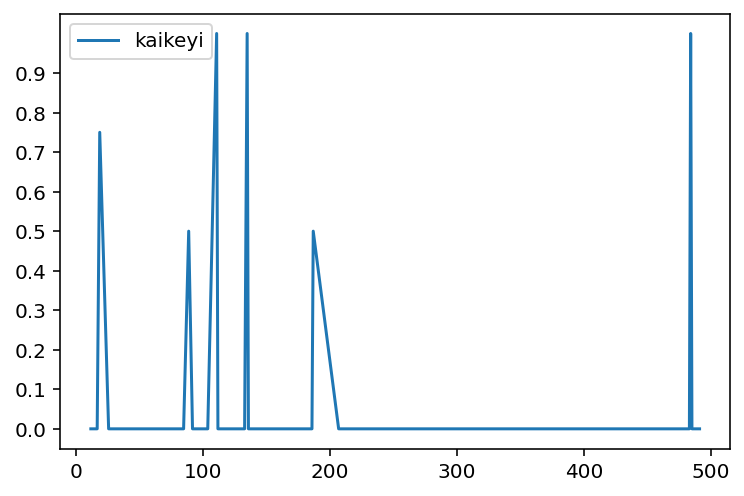

In [115]:
gen_centrality_plot(deg, 0, 280)

In [116]:
partitions = louvain()

In [2]:
from modules import components

In [9]:
components.get_all_chaps()[-1]

'Canto CXXX. The Consecration.'

In [12]:
components.books_to_chaps()['BOOK VI.'][-1]

'Canto CXXX. The Consecration.'